## Imports


In [190]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import pydot
import graphviz
from keras.utils import plot_model

## Preprocessing the Data

### Load Data

In [181]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data = unpickle(f'./Data/data_batch_1')
labels = data[b'labels']
images = data[b'data']
for i in range(2,6):
    data = unpickle(f'./Data/data_batch_{i}')
    labels = np.concatenate((labels, data[b'labels']))
    images = np.concatenate((images,data[b'data']))
data_test = unpickle(f'./Data/test_batch')

labels_test = data_test[b'labels']
images_test = data_test[b'data']
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images.shape

(50000, 3072)

### Reshape Data

In [182]:
images = images.reshape(len(images),3,32,32).transpose(0,2,3,1)
images_test = images_test.reshape(len(images_test),3,32,32).transpose(0,2,3,1)
images.shape

(50000, 32, 32, 3)

### Visualize Some Data

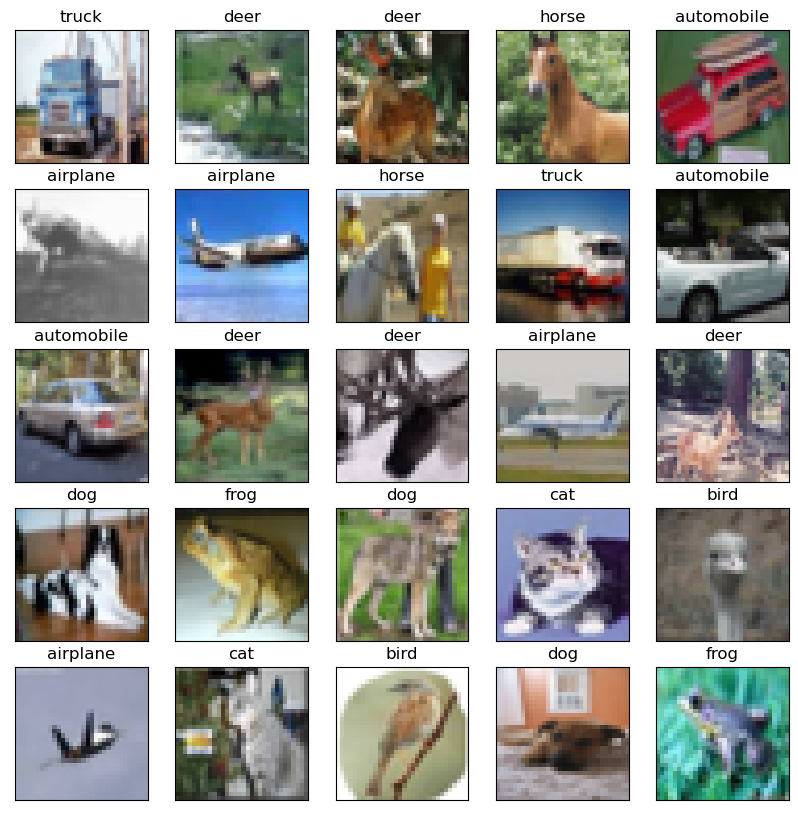

In [183]:
rows, columns = 5, 5
# take random image idex id
imageId = np.random.randint(0, len(images), rows * columns)
# take images for above random image ids
images_to_show = images[imageId]
# take labels for these images only
labels_to_show = [labels[i] for i in imageId]

# define figure
fig=plt.figure(figsize=(10, 10))
# visualize these random images
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images_to_show[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(label_names[labels_to_show[i-1]]))
plt.show()

### Image Augmentation

In [184]:
## Nothing for now


## Model Definition

### Residual Block Definition

In [185]:
def residual_block(X, num_filters: int, stride: int = 1, kernel_size: int = 3,
                   activation: str = 'relu', bn: bool = True, conv_first: bool = True):
    """
    Parameters
    ----------
    X : Tensor layer
        Input tensor from previous layer
    num_filters : int
        Conv2d number of filters
    stride : int by default 1
        Stride square dimension
    kernel_size : int by default 3
        COnv2D square kernel dimensions
    activation: str by default 'relu'
        Activation function to used
    bn: bool by default True
        To use BatchNormalization
    conv_first : bool by default True
        conv-bn-activation (True) or bn-activation-conv (False)
    """
    conv_layer = tf.keras.layers.Conv2D(num_filters,
                        kernel_size=kernel_size,
                        strides=stride,
                        padding='same',
                        kernel_regularizer=tf.keras.regularizers.L2(l2=0.0001))
    # X = input
    if conv_first:
        X = conv_layer(X)
        if bn:
            X = tf.keras.layers.BatchNormalization()(X)
        if activation is not None:
            X = tf.keras.layers.Activation(activation)(X)
            X = tf.keras.layers.Dropout(0.2)(X)
    else:
        if bn:
            X = tf.keras.layers.BatchNormalization()(X)
        if activation is not None:
            X = tf.keras.layers.Activation(activation)(X)
        X = conv_layer(X)

    return X

### Full Model Definition

In [186]:
depth = 20
input_shape = [32, 32, 3]
num_filters_in = 32
num_classes = 10
def create_resnet(depth = depth, input_shape = input_shape, num_filters_in = num_filters_in, num_classes = num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    num_res_block = int((depth - 2) / 9)
    # ResNet V2 performs Conv2D on X before spiting into two path
    X = residual_block(X=inputs, num_filters=num_filters_in, conv_first=True)

    # Building stack of residual units
    for stage in range(3):
        for unit_res_block in range(num_res_block):
            activation = 'relu'
            bn = True
            stride = 1
            # First layer and first stage
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if unit_res_block == 0:
                    activation = None
                    bn = False
                # First layer but not first stage
            else:
                num_filters_out = num_filters_in * 2
                if unit_res_block == 0:
                    stride = 2

            # bottleneck residual unit
            y = residual_block(X,
                               num_filters=num_filters_in,
                               kernel_size=1,
                               stride=stride,
                               activation=activation,
                               bn=bn,
                               conv_first=False)
            y = residual_block(y,
                               num_filters=num_filters_in,
                               conv_first=False)
            y = residual_block(y,
                               num_filters=num_filters_out,
                               kernel_size=1,
                               conv_first=False)
            if unit_res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                X = residual_block(X=X,
                                   num_filters=num_filters_out,
                                   kernel_size=1,
                                   stride=stride,
                                   activation=None,
                                   bn=False)
            X = tf.keras.layers.add([X, y])
        num_filters_in = num_filters_out

    X = tf.keras.layers.BatchNormalization()(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.AveragePooling2D(pool_size=8)(X)
    y = tf.keras.layers.Flatten()(X)
    y = tf.keras.layers.Dense(512, activation='relu')(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Dropout(0.5)(y)

    outputs = tf.keras.layers.Dense(num_classes,
                    activation='softmax')(y)

    # Instantiate model.
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

### Model Summary

In [187]:
model = create_resnet(depth = 11)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_176 (Conv2D)            (None, 32, 32, 32)   896         ['input_14[0][0]']               
                                                                                                  
 batch_normalization_160 (Batch  (None, 32, 32, 32)  128         ['conv2d_176[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_152 (Activation)    (None, 32, 32, 32)   0           ['batch_normalization_160[0

                                                                                                  
 add_50 (Add)                   (None, 8, 8, 512)    0           ['conv2d_188[0][0]',             
                                                                  'conv2d_187[0][0]']             
                                                                                                  
 batch_normalization_169 (Batch  (None, 8, 8, 512)   2048        ['add_50[0][0]']                 
 Normalization)                                                                                   
                                                                                                  
 activation_161 (Activation)    (None, 8, 8, 512)    0           ['batch_normalization_169[0][0]']
                                                                                                  
 average_pooling2d_8 (AveragePo  (None, 1, 1, 512)   0           ['activation_161[0][0]']         
 oling2D) 

### Compile Model

In [188]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Train Model

In [ ]:
model.fit(x = images, y = np.array(labels), epochs = 20, validation_data = (images_test, np.array(labels_test)))

Epoch 1/20
1563/1563 [==============================] - 248s 159ms/step - loss: 0.6547 - accuracy: 0.8676 - val_loss: 1.1240 - val_accuracy: 0.7480
Epoch 2/20
1563/1563 [==============================] - 249s 159ms/step - loss: 0.6499 - accuracy: 0.8688 - val_loss: 0.9936 - val_accuracy: 0.7722
Epoch 3/20
1563/1563 [==============================] - 250s 160ms/step - loss: 0.6416 - accuracy: 0.8752 - val_loss: 0.9668 - val_accuracy: 0.7851
Epoch 4/20
1563/1563 [==============================] - 244s 156ms/step - loss: 0.6330 - accuracy: 0.8769 - val_loss: 0.9342 - val_accuracy: 0.7957
Epoch 5/20
1563/1563 [==============================] - 247s 158ms/step - loss: 0.6303 - accuracy: 0.8794 - val_loss: 1.1285 - val_accuracy: 0.7484
Epoch 6/20
1563/1563 [==============================] - 253s 162ms/step - loss: 0.6282 - accuracy: 0.8811 - val_loss: 1.0631 - val_accuracy: 0.7602
Epoch 7/20
1563/1563 [==============================] - 248s 159ms/step - loss: 0.6150 - accuracy: 0.8845 - val_

## Save Model

In [191]:
model.save('model.h5')